In [1]:
# all the libs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data Pre-Processing
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Set the root directory where "RealWaste" is located
data_dir = '/content/drive/MyDrive/Colab Notebooks/stat453/project/RealWaste'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Define the transformation pipeline
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

# No transform in ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# calculate the sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% train
test_size = total_size - train_size

# Split
db_train, db_test = random_split(dataset, [train_size, test_size])

# Wrap with transforms
db_train = SubsetWithTransform(db_train, transform_train)
db_test = SubsetWithTransform(db_test, transform_test)

# Define the data loaders
loader_train = DataLoader(db_train, batch_size=32, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=32, shuffle=False)

In [5]:
# training utils
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [6]:
# Train
def train(model, loader_train, loader_test, epochs=5, lr=0.01):

  # Define the optimizer
  opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

  # Fit the model to our data
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # eval
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [7]:
# Fine tuning
def fine_tuning(model, loader_train, loader_test, epochs=2, lr=0.001):

    # Unfreeze the entire model for fine-tuning
  for p in model.parameters():
      p.requires_grad = True

  # Define optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

  # Training
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # Testing
  loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    # Unique class labels from the dataset
    labels_list = list(range(len(dataset.classes)))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_normalized = cm / cm.sum(axis=0, keepdims=True)  # Normalize by column (actual label)

    # Confusion matrix heatmap (x = Actual, y = Predicted)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_normalized.T, annot=cm.T, fmt='d', cmap="Blues",
        xticklabels=dataset.classes, yticklabels=dataset.classes,
        cbar_kws={"label": "Percentage of Actual Label"}
    )
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels_list, average=None)
    recall = recall_score(y_true, y_pred, labels=labels_list, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels_list, average=None)

    print(f"\nAccuracy: {acc:.4f}")
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        class_name = dataset.classes[i]
        print(f"Class {i} ({class_name}): Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")

    # Macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\nMacro-Averaged Metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1 Score:  {macro_f1:.4f}")

In [19]:
# train-fine-tune-pipeline
def pipeline(model, name):
  global db_train, db_test, loader_train, loader_test

  # Define the model for 9-class classification
  if 'vgg' in name: #for vgg16
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, 9)
  elif 'convnext' in name:
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 9)
  elif hasattr(model, 'fc'):  # For DenseNet and other models
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 9)


  # Move entire model to device
  model = model.to(device)

  # Freeze feature extractor for ResNet and Wide ResNet
  if hasattr(model, 'fc'): # check for ResNet/WideResNet
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
  else: # assuming models with features attr here.
    for param in model.features.parameters():
        param.requires_grad = False

  # Test the model with one batch to confirm it works
  image_batch, label_batch = db_train[0]
  feature_batch = model(image_batch[None].to(device))

  # Train the model
  train(model, loader_train, loader_test, epochs=8, lr = 0.01)

  # fine tune
  fine_tuning(model, loader_train, loader_test, epochs=10, lr=0.001)

  return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.3MB/s]
100%|██████████| 118/118 [24:11<00:00, 12.30s/it]

Finished epoch 0 of 8: Train Loss = 1.191  Val Loss = 2.245   Train Acc = 0.619   Val Acc = 0.104



100%|██████████| 118/118 [00:43<00:00,  2.74it/s]

Finished epoch 1 of 8: Train Loss = 0.709  Val Loss = 0.803   Train Acc = 0.773   Val Acc = 0.728



100%|██████████| 118/118 [00:34<00:00,  3.42it/s]

Finished epoch 2 of 8: Train Loss = 0.547  Val Loss = 0.637   Train Acc = 0.825   Val Acc = 0.784



100%|██████████| 118/118 [00:34<00:00,  3.38it/s]

Finished epoch 3 of 8: Train Loss = 0.370  Val Loss = 0.774   Train Acc = 0.882   Val Acc = 0.775



100%|██████████| 118/118 [00:34<00:00,  3.41it/s]

Finished epoch 4 of 8: Train Loss = 0.473  Val Loss = 0.871   Train Acc = 0.868   Val Acc = 0.783



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

Finished epoch 5 of 8: Train Loss = 0.359  Val Loss = 1.010   Train Acc = 0.901   Val Acc = 0.767



100%|██████████| 118/118 [00:34<00:00,  3.38it/s]

Finished epoch 6 of 8: Train Loss = 0.288  Val Loss = 0.873   Train Acc = 0.923   Val Acc = 0.793



100%|██████████| 118/118 [00:35<00:00,  3.35it/s]

Finished epoch 7 of 8: Train Loss = 0.264  Val Loss = 0.876   Train Acc = 0.930   Val Acc = 0.800



100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


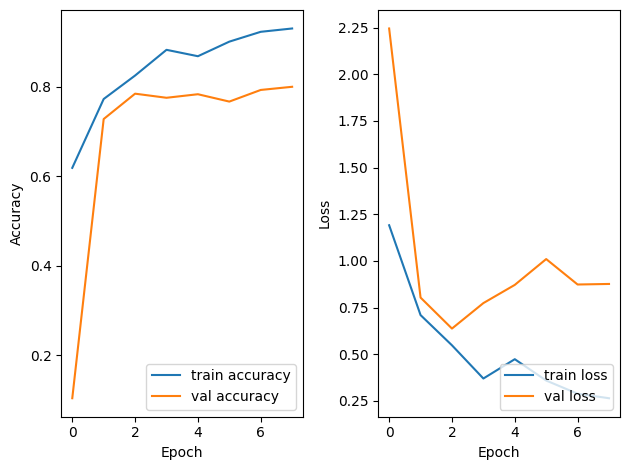

Test accuracy: 78.26%
Test loss: 1.127


100%|██████████| 118/118 [00:39<00:00,  2.96it/s]

Finished epoch 0 of 10: Train Loss = 0.234  Val Loss = 1.127   Train Acc = 0.930   Val Acc = 0.783



100%|██████████| 118/118 [00:39<00:00,  2.97it/s]

Finished epoch 1 of 10: Train Loss = 0.097  Val Loss = 0.609   Train Acc = 0.973   Val Acc = 0.845



100%|██████████| 118/118 [00:39<00:00,  2.96it/s]

Finished epoch 2 of 10: Train Loss = 0.049  Val Loss = 0.571   Train Acc = 0.986   Val Acc = 0.845



100%|██████████| 118/118 [00:40<00:00,  2.94it/s]

Finished epoch 3 of 10: Train Loss = 0.032  Val Loss = 0.720   Train Acc = 0.990   Val Acc = 0.852



100%|██████████| 118/118 [00:39<00:00,  2.95it/s]

Finished epoch 4 of 10: Train Loss = 0.041  Val Loss = 0.654   Train Acc = 0.989   Val Acc = 0.862



100%|██████████| 118/118 [00:39<00:00,  2.97it/s]

Finished epoch 5 of 10: Train Loss = 0.019  Val Loss = 0.614   Train Acc = 0.994   Val Acc = 0.855



100%|██████████| 118/118 [00:39<00:00,  2.96it/s]

Finished epoch 6 of 10: Train Loss = 0.028  Val Loss = 0.672   Train Acc = 0.991   Val Acc = 0.847



100%|██████████| 118/118 [00:39<00:00,  2.97it/s]

Finished epoch 7 of 10: Train Loss = 0.009  Val Loss = 0.701   Train Acc = 0.997   Val Acc = 0.852



100%|██████████| 118/118 [00:39<00:00,  2.97it/s]

Finished epoch 8 of 10: Train Loss = 0.009  Val Loss = 0.687   Train Acc = 0.997   Val Acc = 0.847



100%|██████████| 118/118 [00:39<00:00,  2.96it/s]

Finished epoch 9 of 10: Train Loss = 0.017  Val Loss = 0.746   Train Acc = 0.994   Val Acc = 0.853



100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


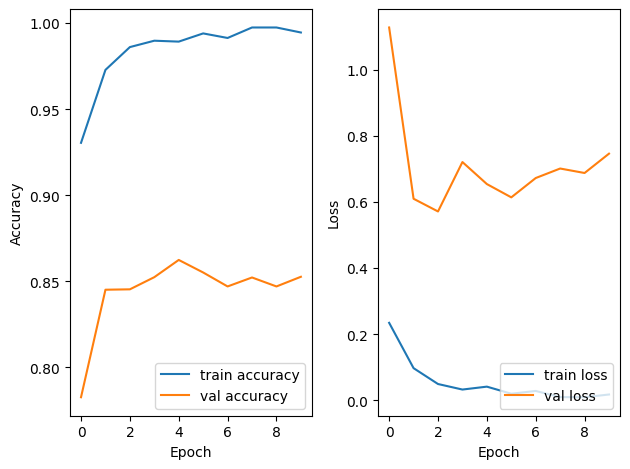

Test accuracy: 86.63%
Test loss: 0.666


In [11]:
# mobilenet_v2
vgg16 = pipeline(models.vgg16(pretrained=True), name='vgg16')

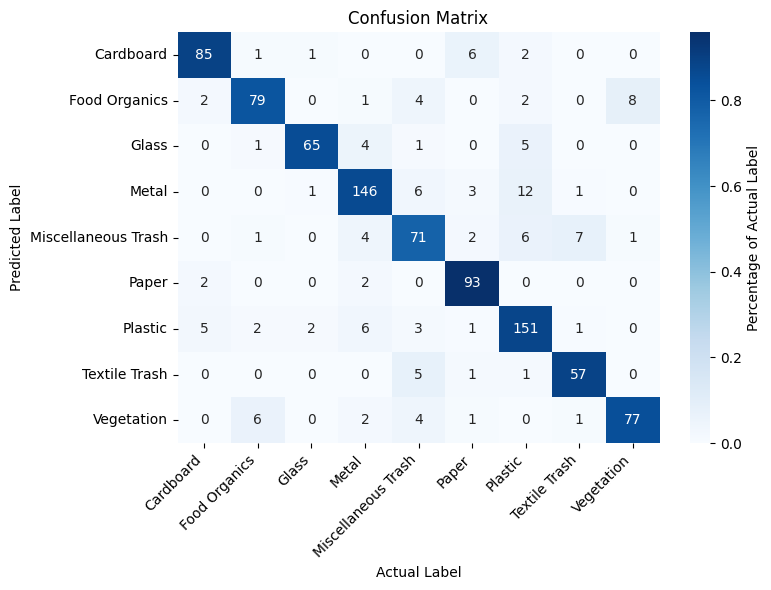


Accuracy: 0.8665
Class 0 (Cardboard): Precision: 0.8947, Recall: 0.9043, F1 Score: 0.8995
Class 1 (Food Organics): Precision: 0.8229, Recall: 0.8778, F1 Score: 0.8495
Class 2 (Glass): Precision: 0.8553, Recall: 0.9420, F1 Score: 0.8966
Class 3 (Metal): Precision: 0.8639, Recall: 0.8848, F1 Score: 0.8743
Class 4 (Miscellaneous Trash): Precision: 0.7717, Recall: 0.7553, F1 Score: 0.7634
Class 5 (Paper): Precision: 0.9588, Recall: 0.8692, F1 Score: 0.9118
Class 6 (Plastic): Precision: 0.8830, Recall: 0.8436, F1 Score: 0.8629
Class 7 (Textile Trash): Precision: 0.8906, Recall: 0.8507, F1 Score: 0.8702
Class 8 (Vegetation): Precision: 0.8462, Recall: 0.8953, F1 Score: 0.8701

Macro-Averaged Metrics:
Precision: 0.8652
Recall:    0.8692
F1 Score:  0.8665


In [12]:
evaluate_metrics(vgg16, loader_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 216MB/s]
100%|██████████| 118/118 [00:42<00:00,  2.81it/s]

Finished epoch 0 of 8: Train Loss = 0.889  Val Loss = 2.291   Train Acc = 0.698   Val Acc = 0.066



100%|██████████| 118/118 [00:41<00:00,  2.86it/s]

Finished epoch 1 of 8: Train Loss = 0.480  Val Loss = 0.521   Train Acc = 0.844   Val Acc = 0.829



100%|██████████| 118/118 [00:41<00:00,  2.85it/s]

Finished epoch 2 of 8: Train Loss = 0.401  Val Loss = 0.460   Train Acc = 0.875   Val Acc = 0.842



100%|██████████| 118/118 [00:41<00:00,  2.86it/s]

Finished epoch 3 of 8: Train Loss = 0.358  Val Loss = 0.422   Train Acc = 0.885   Val Acc = 0.863



100%|██████████| 118/118 [00:41<00:00,  2.84it/s]

Finished epoch 4 of 8: Train Loss = 0.344  Val Loss = 0.402   Train Acc = 0.890   Val Acc = 0.870



100%|██████████| 118/118 [00:41<00:00,  2.83it/s]

Finished epoch 5 of 8: Train Loss = 0.312  Val Loss = 0.395   Train Acc = 0.897   Val Acc = 0.880



100%|██████████| 118/118 [00:41<00:00,  2.82it/s]

Finished epoch 6 of 8: Train Loss = 0.296  Val Loss = 0.370   Train Acc = 0.901   Val Acc = 0.878



100%|██████████| 118/118 [00:41<00:00,  2.84it/s]

Finished epoch 7 of 8: Train Loss = 0.281  Val Loss = 0.354   Train Acc = 0.910   Val Acc = 0.883



100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


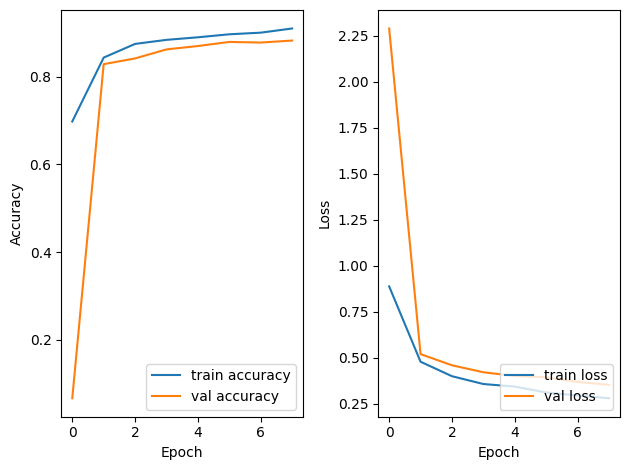

Test accuracy: 87.98%
Test loss: 0.352


100%|██████████| 118/118 [01:09<00:00,  1.69it/s]

Finished epoch 0 of 10: Train Loss = 0.411  Val Loss = 0.352   Train Acc = 0.855   Val Acc = 0.880



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 1 of 10: Train Loss = 0.284  Val Loss = 0.477   Train Acc = 0.902   Val Acc = 0.840



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 2 of 10: Train Loss = 0.203  Val Loss = 0.353   Train Acc = 0.933   Val Acc = 0.879



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 3 of 10: Train Loss = 0.147  Val Loss = 0.336   Train Acc = 0.951   Val Acc = 0.877



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 4 of 10: Train Loss = 0.132  Val Loss = 0.336   Train Acc = 0.959   Val Acc = 0.891



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 5 of 10: Train Loss = 0.099  Val Loss = 0.315   Train Acc = 0.971   Val Acc = 0.907



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 6 of 10: Train Loss = 0.085  Val Loss = 0.285   Train Acc = 0.979   Val Acc = 0.909



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 7 of 10: Train Loss = 0.061  Val Loss = 0.323   Train Acc = 0.985   Val Acc = 0.899



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 8 of 10: Train Loss = 0.051  Val Loss = 0.290   Train Acc = 0.990   Val Acc = 0.910



100%|██████████| 118/118 [01:09<00:00,  1.70it/s]

Finished epoch 9 of 10: Train Loss = 0.042  Val Loss = 0.276   Train Acc = 0.992   Val Acc = 0.917



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


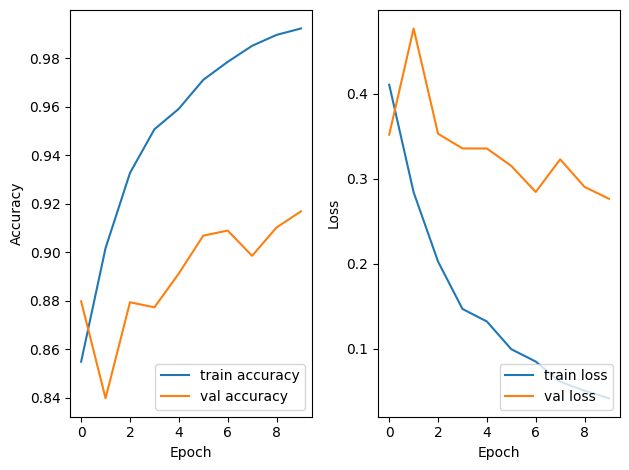

Test accuracy: 92.24%
Test loss: 0.271


In [20]:
convnext = pipeline(models.convnext_base(pretrained=True), name='convnext')

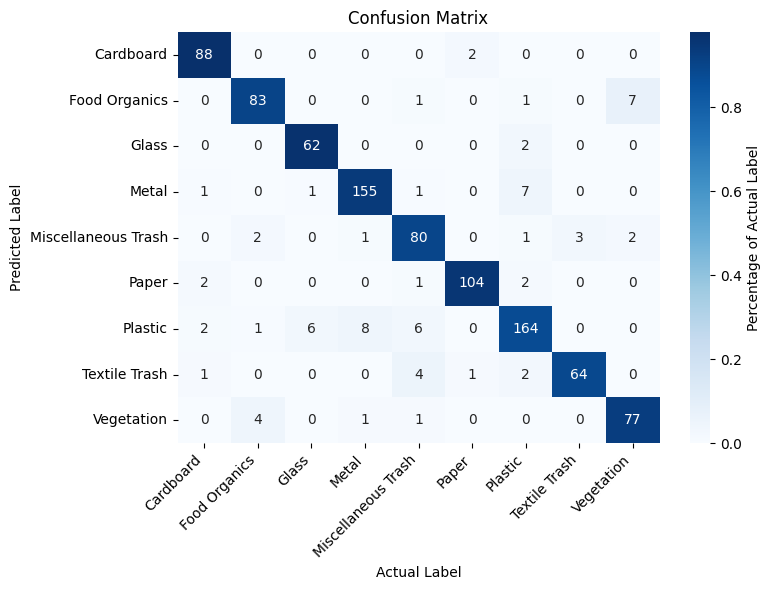


Accuracy: 0.9222
Class 0 (Cardboard): Precision: 0.9778, Recall: 0.9362, F1 Score: 0.9565
Class 1 (Food Organics): Precision: 0.9022, Recall: 0.9222, F1 Score: 0.9121
Class 2 (Glass): Precision: 0.9688, Recall: 0.8986, F1 Score: 0.9323
Class 3 (Metal): Precision: 0.9394, Recall: 0.9394, F1 Score: 0.9394
Class 4 (Miscellaneous Trash): Precision: 0.8989, Recall: 0.8511, F1 Score: 0.8743
Class 5 (Paper): Precision: 0.9541, Recall: 0.9720, F1 Score: 0.9630
Class 6 (Plastic): Precision: 0.8770, Recall: 0.9162, F1 Score: 0.8962
Class 7 (Textile Trash): Precision: 0.8889, Recall: 0.9552, F1 Score: 0.9209
Class 8 (Vegetation): Precision: 0.9277, Recall: 0.8953, F1 Score: 0.9112

Macro-Averaged Metrics:
Precision: 0.9261
Recall:    0.9207
F1 Score:  0.9229


In [21]:
evaluate_metrics(convnext, loader_test)